In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pynwb import NWBHDF5IO

In [2]:
DATA_PATH = 'data/celegans_time_data/sub-2022-06-14-01-SWF702_ses-20220614_behavior+image+ophys.nwb'

In [3]:
with NWBHDF5IO(DATA_PATH, 'r') as io:
    nwbfile = io.read()
    print(f"Identifier: {nwbfile.identifier}")
    print(f"Session Description: {nwbfile.session_description}")
    print(nwbfile.session_start_time)
    
    for name, data in nwbfile.acquisition.items():
        print(f"Acquisition: {name}")
    
    for module in nwbfile.processing.values():
        print(f"Processing module: {module.name}")
        
    for device in nwbfile.devices.values():
        print(f"Device: {device.name}")

Identifier: 2022-06-14-01
Session Description: Ventral cord at the bottom when head points to the left on confocal images (what the neuronal manual suggests)
Young adult with a few mature eggs
Some pumps here and there
Coiling for ~5 loops at t~220, coiling for ~5 loops again at t~510, coiling again for ~5 loop at t~810, coiling briefly again t ~1100, long coiling ~8 loops at t~1400, long coiling again t~1550
The second half is slightly out of focus (the edge of 3-5 neurons at the upper border in z-dimension), should not affect registration in candy’s experience

2022-06-14 00:00:00-07:00
Acquisition: CalciumImageSeries
Acquisition: NeuroPALImageRaw
Processing module: BF_NIR
Processing module: Behavior
Processing module: CalciumActivity
Processing module: NeuroPAL
Device: NIR Config
Device: Spinning Disk Confocal


In [7]:
ca = nwbfile.processing['CalciumActivity']
print("Data interfaces in CalciumActivity:", list(ca.data_interfaces.keys()))

Data interfaces in CalciumActivity: ['CalciumSeriesSegmentation', 'NeuronIDs', 'SignalRawFluor', 'SignalCalciumImResponseSeries']


In [11]:
io  = NWBHDF5IO(DATA_PATH,'r')
nwb = io.read()
rcs = nwb.processing['CalciumActivity'].data_interfaces['SignalCalciumImResponseSeries']
# rcs = nwb.processing['CalciumActivity'].data_interfaces['SignalRawFluor']
print(rcs)
region = rcs.rois          
idxs   = region.data[:]   

table = region.table     
all_labels = table['ID_labels'][:]
names = all_labels[idxs]
data  = rcs.data[:]        # shape (T, N): T timepoints × N neurons
times = rcs.timestamps[:] 

valid_indices = [i for i, name in enumerate(names) if name != '']
names = names[valid_indices]
data = data[:, valid_indices]
T, N = data.shape
io.close()


SignalCalciumImResponseSeries pynwb.ophys.RoiResponseSeries at 0x139857177300800
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (1600, 109), type "<f8">
  description: Raw calcium fluorescence activity
  interval: 1
  offset: 0.0
  resolution: -1.0
  rois: rois <class 'hdmf.common.table.DynamicTableRegion'>
  timestamps: <HDF5 dataset "timestamps": shape (1600,), type "<f8">
  timestamps_unit: seconds
  unit: lumens



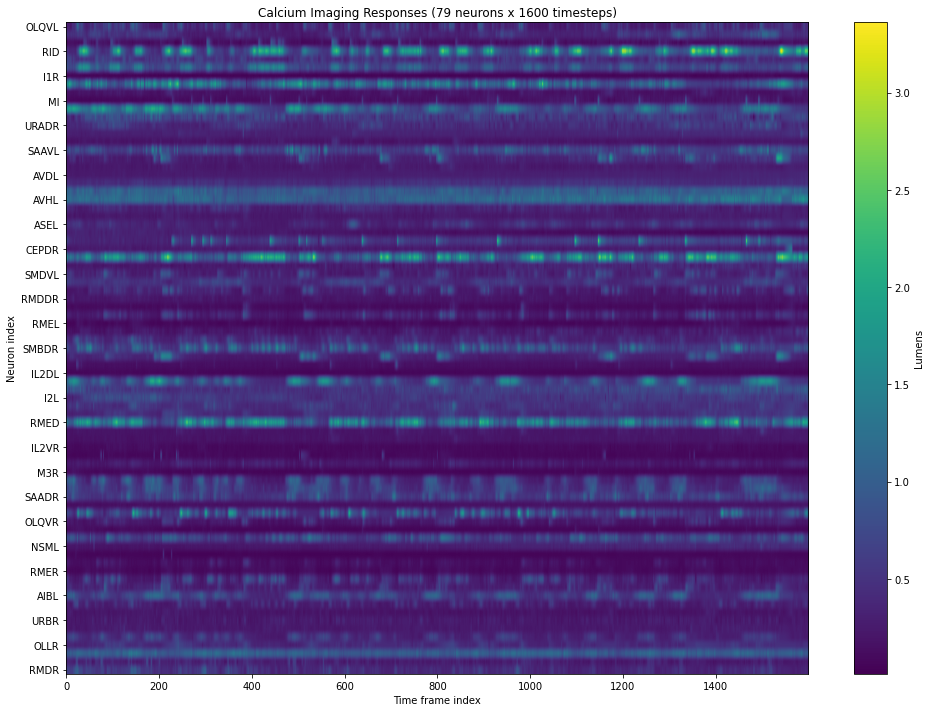

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 10))
img = plt.imshow(data.T, aspect='auto')
plt.xlabel('Time frame index')
plt.ylabel('Neuron index')
plt.title(f'Calcium Imaging Responses ({N} neurons x {T} timesteps)')

cbar = plt.colorbar(img)
cbar.set_label('Lumens')

k = max(1, N // 20)
ticks = np.arange(0, N, k)
plt.yticks(ticks, [names[i] for i in ticks])

plt.tight_layout()
plt.show()


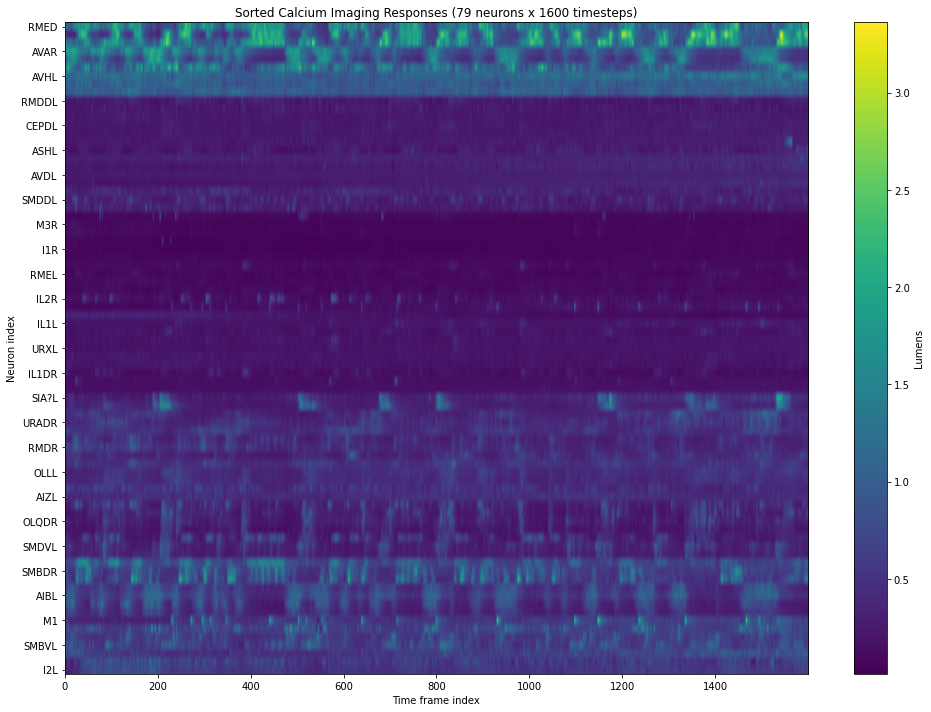

In [24]:
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram

linkage_matrix = linkage(data.T, method='ward') 
sorted_indices = leaves_list(linkage_matrix)

sorted_data = data[:, sorted_indices]
sorted_names = names[sorted_indices]

plt.figure(figsize=(14, 10))
img = plt.imshow(sorted_data.T, aspect='auto')
plt.xlabel('Time frame index')
plt.ylabel('Neuron index')
plt.title(f'Sorted Calcium Imaging Responses ({N} neurons x {T} timesteps)')

cbar = plt.colorbar(img)
cbar.set_label('Lumens')

k = max(1, N // 20)
ticks = np.arange(0, N, k)
plt.yticks(ticks, [sorted_names[i] for i in ticks])

plt.tight_layout()
plt.show()

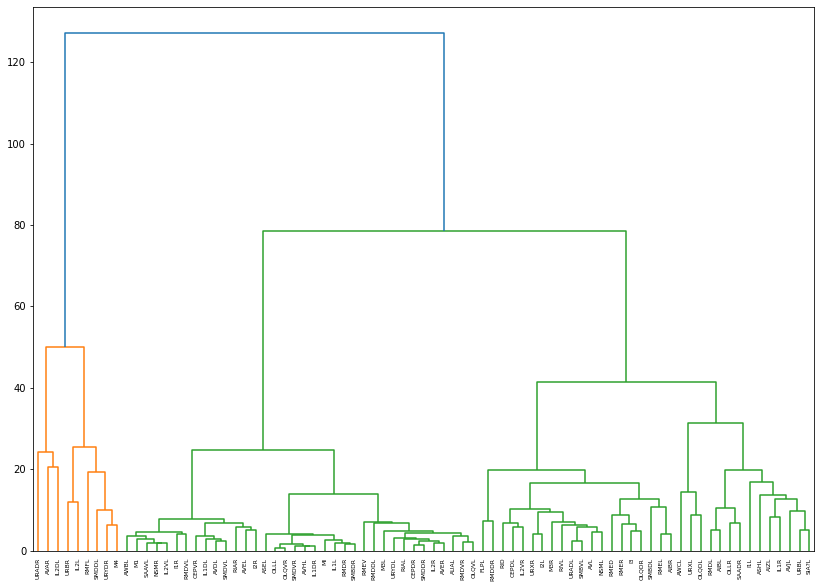

In [26]:
fig = plt.figure(figsize=(14, 10))
dn = dendrogram(linkage_matrix, labels=names[sorted_indices])
plt.xticks(rotation=90)
plt.show()

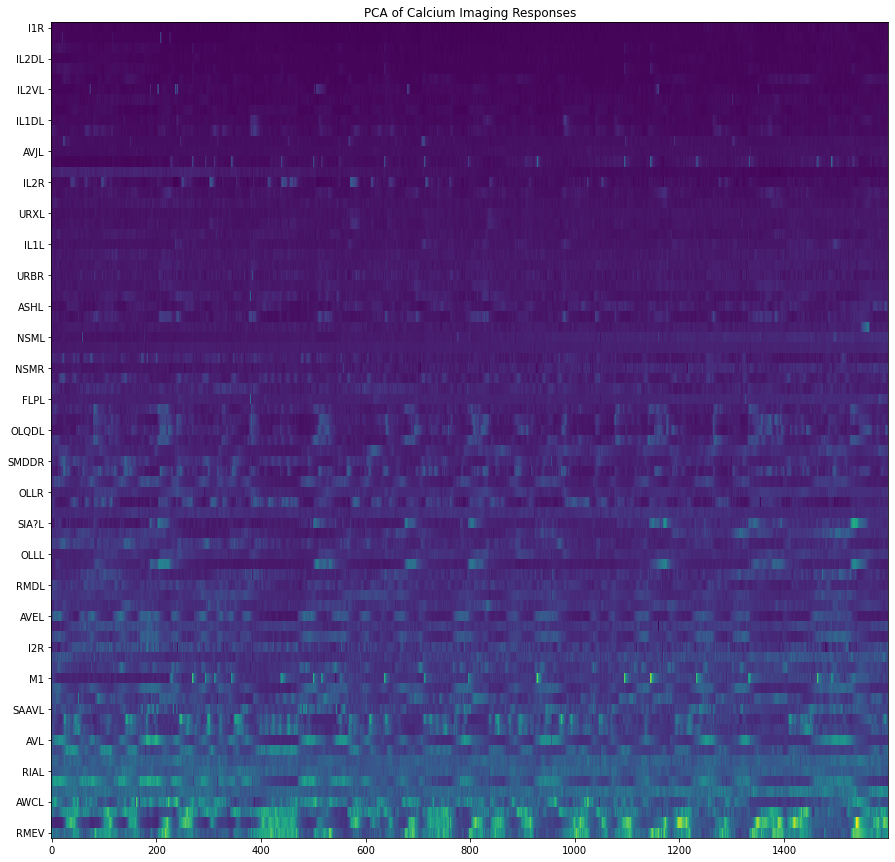

In [23]:
from sklearn.decomposition import PCA

transposed_data = data.T

pca = PCA(n_components=1)
transformed_data = pca.fit_transform(transposed_data)
sorted_data = np.argsort(transformed_data, axis=0)
sorted_neuron_labels = names[sorted_data[:,0]]
plt.figure(figsize=(15, 15))
plt.title('PCA of Calcium Imaging Responses')
plt.imshow(transposed_data[sorted_data[:,0],:], interpolation='nearest', aspect='auto')
k = max(1, N // 20)
ticks = np.arange(0, N, k)
plt.yticks(ticks, [sorted_neuron_labels[i] for i in ticks])
plt.show()

In [34]:
io  = NWBHDF5IO(DATA_PATH,'r')
nwb = io.read()
beh = nwb.processing['Behavior']
print(beh)
io.close()

Behavior pynwb.base.ProcessingModule at 0x139857031669312
Fields:
  data_interfaces: {
    angular_velocity <class 'pynwb.behavior.BehavioralTimeSeries'>,
    body_curvature <class 'pynwb.behavior.BehavioralTimeSeries'>,
    dorsalness <class 'pynwb.behavior.BehavioralTimeSeries'>,
    feedingness <class 'pynwb.behavior.BehavioralTimeSeries'>,
    forwardness <class 'pynwb.behavior.BehavioralTimeSeries'>,
    head_curvature <class 'pynwb.behavior.BehavioralTimeSeries'>,
    pumping <class 'pynwb.behavior.BehavioralTimeSeries'>,
    reversal_events <class 'pynwb.behavior.BehavioralEvents'>,
    velocity <class 'pynwb.behavior.BehavioralTimeSeries'>
  }
  description: Behavioral data



In [ ]:
import pandas as pd
io  = NWBHDF5IO(DATA_PATH,'r')
nwb = io.read()
beh = nwb.processing['Behavior']
series_dict = {}
for name, iface in beh.data_interfaces.items():
    if name in ('dorsalness', 'feedingness', 'forwardness'):
        continue
    time_series_data = iface.time_series[name].data[:]
    series_dict[name] = pd.Series(time_series_data, index=list(range(len(time_series_data))))
all_times = np.unique(np.concatenate([s.index.values for s in series_dict.values()]))
all_times.sort()

df = pd.DataFrame(index=all_times)
for name, s in series_dict.items():
    df[name] = s.reindex(all_times)

io.close()
df

,angular_velocity,body_curvature,head_curvature,pumping,reversal_events,velocity
0,-0.106008,0.772148,-0.497797,0.521262,0.0,-0.127370
1,-0.100544,0.927859,-0.580070,0.740741,1.0,-0.098665
2,-0.091799,1.009937,0.054525,0.561167,1.0,-0.076460
3,-0.070044,0.871521,0.478702,0.493827,1.0,-0.127356
4,-0.044707,0.605583,0.702458,0.561167,1.0,-0.081678
...,...,...,...,...,...,...
1595,0.102241,0.690796,-0.495107,0.000000,0.0,0.045393
1596,0.084478,0.696883,-0.695141,0.000000,0.0,0.034851
1597,0.065708,0.675533,-0.414129,0.000000,0.0,0.040778
1598,0.044814,0.640761,-0.109278,0.000000,0.0,0.051143


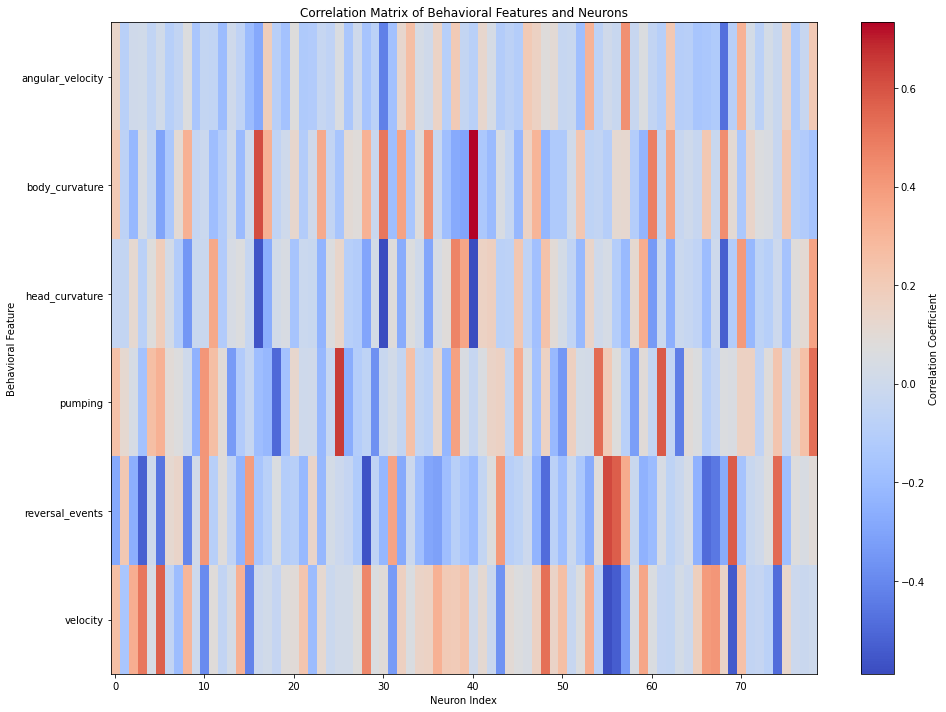

In [56]:
correlation_results = {}

for column in df.columns:
    correlations = []
    for neuron_idx in range(data.shape[1]):
        correlation = np.corrcoef(df[column], data[:, neuron_idx])[0, 1]
        correlations.append(correlation)
    correlation_results[column] = correlations

correlation_results

plt.figure(figsize=(14, 10))
correlation_matrix = np.array(list(correlation_results.values()))
plt.imshow(correlation_matrix, aspect='auto', cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation Coefficient')
plt.xlabel('Neuron Index')
plt.ylabel('Behavioral Feature')
plt.yticks(ticks=np.arange(len(df.columns)), labels=df.columns)
plt.title('Correlation Matrix of Behavioral Features and Neurons')
plt.tight_layout()
plt.show()

In [69]:
def get_correlation_vector(neuron):
    """
    Returns a correlation vector for a given neuron index.

    """
    if isinstance(neuron, str):
        neuron_idx = np.where(names == neuron)[0][0]
        if not isinstance(neuron_idx, np.int64):
            raise ValueError(f"Neuron {neuron} not found in the dataset.")
    correlation_vector = np.array([correlation_results[interface][neuron_idx] for interface in correlation_results.keys()])
    return correlation_vector

print(get_correlation_vector('IL2DL'))

[ 0.031212   -0.20465226  0.17531557  0.148532    0.07109159 -0.02041395]


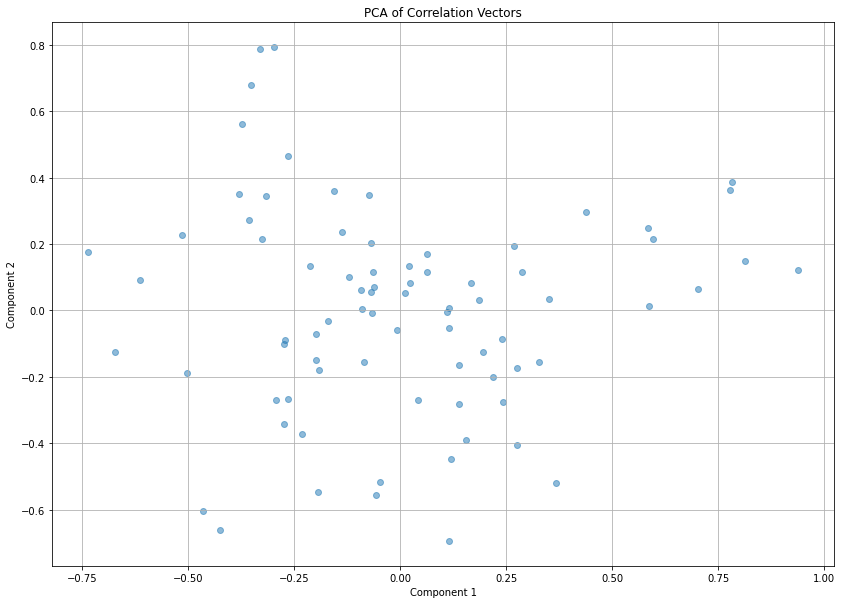

In [71]:
correlation_vec_mat = np.vstack([get_correlation_vector(neuron) for neuron in names])

# use PCA to reduce the dimensionality of corr vectors to 2D
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(correlation_vec_mat)
plt.figure(figsize=(14, 10))
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.5)
plt.title('PCA of Correlation Vectors')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid()
plt.show()

In [77]:
from sklearn.metrics.pairwise import cosine_similarity

sim_df = pd.DataFrame(columns = ['neuron1', 'neuron2', 'cosine_similarity'])
cosine_sim_matrix = cosine_similarity(correlation_vec_mat)

for i, neuron in enumerate(names):
    cosine_sim_matrix[i, i] = -1
    closest_idx = np.argmax(cosine_sim_matrix[i])
    sim_df = pd.concat([sim_df, pd.DataFrame({
        'neuron1': [neuron],
        'neuron2': [names[closest_idx]],
        'cosine_similarity': [cosine_sim_matrix[i, closest_idx]]
    })], ignore_index=True)
    
sim_df
# sim_df.to_csv('data/timeseries_corr_pairs.csv', index=False)

,neuron1,neuron2,cosine_similarity
0,OLQVL,RMEL,0.844620
1,URADL,AVL,0.935526
2,IL2R,RMED,0.969010
3,RID,IL1R,0.956220
4,RMDL,I3,0.951542
...,...,...,...
74,AVER,AVEL,0.992811
75,OLLR,OLQDL,0.977593
76,RIAL,I1R,0.897489
77,RIAR,I3,0.938710


In [79]:
hamming_df = pd.read_csv('data/min_hamming.csv')
merged_df = pd.merge(sim_df, hamming_df, left_on='neuron1', right_on='Neuron')
merged_df = merged_df.drop(columns=['Neuron'])
merged_df

,neuron1,neuron2,cosine_similarity,Closest Neurons
0,OLQVL,RMEL,0.844620,['URYVL']
1,URADL,AVL,0.935526,['RMGR']
2,IL2R,RMED,0.969010,"['IL2VL', 'RMGL']"
3,RID,IL1R,0.956220,['RMGR']
4,RMDL,I3,0.951542,"['IL2V4', 'SIBVR']"
...,...,...,...,...
70,AVER,AVEL,0.992811,['AVAL']
71,OLLR,OLQDL,0.977593,['MI']
72,RIAL,I1R,0.897489,['RMGR']
73,RIAR,I3,0.938710,['RIAL']


In [82]:
merged_df['match'] = merged_df.apply(lambda row: row['neuron2'] in eval(row['Closest Neurons']), axis=1)
merged_df

,neuron1,neuron2,cosine_similarity,Closest Neurons,match
0,OLQVL,RMEL,0.844620,['URYVL'],False
1,URADL,AVL,0.935526,['RMGR'],False
2,IL2R,RMED,0.969010,"['IL2VL', 'RMGL']",False
3,RID,IL1R,0.956220,['RMGR'],False
4,RMDL,I3,0.951542,"['IL2V4', 'SIBVR']",False
...,...,...,...,...,...
70,AVER,AVEL,0.992811,['AVAL'],False
71,OLLR,OLQDL,0.977593,['MI'],False
72,RIAL,I1R,0.897489,['RMGR'],False
73,RIAR,I3,0.938710,['RIAL'],False
